<a href="https://colab.research.google.com/github/Antonio96128/Anomaly_Detection_algorithms/blob/master/Anomaly_Detection_Study_Cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is this notebook about?

Along this notebook we will review some machine learning techniques used to detect anomalies. But, what do we mean by anomalies? Well, anomalies can be understood as very rare events. For instance, when we deal with credit card transactions, most of the time we have valid transactions, but once in a while someone is able to commmit a fraud. Another interesting example has to do with detecting defective products in a factory. As we can infer, the dataset will be usually highly imbalanced (just a couple of anomaly examples) since people do their best to not loose money to this rare events. The latter, is maybe the main difficulty we have to overcome when we try to write a machine algorithm that is able to spot the anomalies.

First, we will review a dataset provided by the platform Machine Hack, https://www.machinehack.com/. This is a great place to test your machine learning abilities because you can compete in Weekend Hackatons, which have more realistic and challenguing datasets. We will focus on the Weekend Hackathon 18: "Detecting Anomalies in Wafer Manufacturing", https://www.machinehack.com/hackathons/detecting_anomalies_in_wafer_manufacturing_weekend_hackathon_18.

The goal of this hackaton was to detect defective products, based on certain anonimized features. The metric to optimize was the ROC-AUC score, so we will do that first, and I will show you, among other things, the algorithm and hyperparameter tuning strategy that let me rank 22 out of 173 active submissions. By the way, in case you are not familiarized with ROC-AUC, I strongly suggest you to watch this video https://www.youtube.com/watch?v=4jRBRDbJemM&t=1s. 

In the second part of the notebook, we will apply other commonly used anomaly detection techniques, like autoencoders and isolation forests.

# Importing libraries

In [1]:

import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss, mean_squared_error, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler



from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# First part

In [2]:
dataset  =  pd.read_csv('Train.csv')  ###  We will use this dataset to train and validate our model, the reason the 
                                      ###  file is named "Train" is because for the competition we have another file
                                      ###  named "Test", used to make submissions and evaluate the model FOR REAL.        
        

dataset

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,1,1,2.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1759,40,200,5.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1760,96,218,2.2708,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1761,16,81,5.0625,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
dataset.Class.value_counts()

0    1620
1     143
Name: Class, dtype: int64

As we can notice we have a large number of (anonimized) features, so we have to come up with a solution for that. Also, we can notice that most of the points are NOT ANOMALIES (CLASS 1).

In [4]:
### PREPARING DATA

y = dataset.Class.copy()
y = np.array(y)

dataset.drop(columns = ['Class'], axis = 1 , inplace = True)

X = dataset.copy()
X = np.array(X)


Before we continue, we notice something rather strange... It seems to be that most columns are filled with zeros, so they do not carry useful information. So, what do we do? Well, we could analize them one by one and check the relevance of them, but that is very time consuming. Another option is to use PCA to perform a linear dimensionality reduction, and in this way only keep the (linear combinations of) variables that explain most of the variance.

This dimensionality reduction and the normalization will be performed inside the following functions, in order to exploit cross validation. Notice that we are coding in a very explicit way, but another path would be to use built-in sklearn functions. Personally, I prefer this since I can spot bugs more easily.

Before going into the machine learning algorithms it would be nice to visualize the data, just in case we can do something without the necessity of a more complex approach.

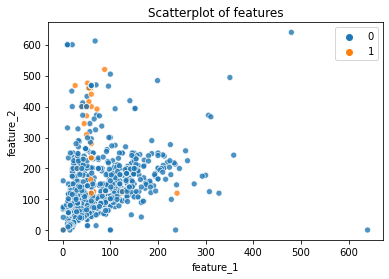

In [5]:
plt.figure("Scatterplot 1")
plt.title("Scatterplot of features")
sns.scatterplot(data = dataset, x ='feature_1' , y = 'feature_2', hue= y, alpha=0.8)

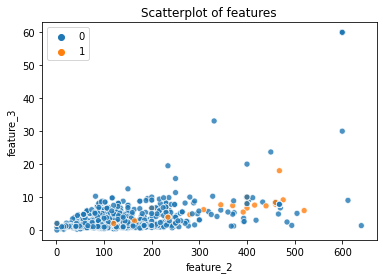

In [6]:
plt.figure("Scatterplot 1")
plt.title("Scatterplot of features")
sns.scatterplot(data = dataset, x ='feature_2' , y = 'feature_3', hue= y, alpha=0.8)

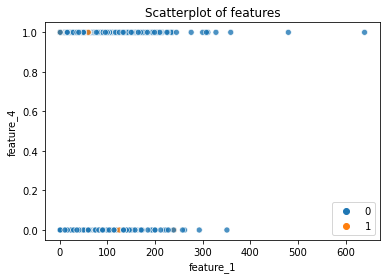

In [7]:
plt.figure("Scatterplot 1")
plt.title("Scatterplot of features")
sns.scatterplot(data = dataset, x ='feature_1' , y = 'feature_4', hue= y, alpha=0.8)

No trivial pattern can be visualized, so let's try a different approach.

We will train a Random Forest Classifier.

In [8]:
def train_RF(X_train, y_train, n_estimators, max_depth, min_samples_leaf):
    
    '''Train a Random Forest Classifier'''

    model_RF = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth,
                                      min_samples_leaf = min_samples_leaf)#, max_features = 4)#, class_weight = 'balanced')
    
    model_RF.fit(X_train, y_train)
        
    train_predictions = model_RF.predict_proba(X_train)
    
    return model_RF, train_predictions[:,1]


In [9]:

def CV(X, y, k_fold, n_estimators, max_depth, min_samples_leaf, n_components):
    
    '''CROSS VALIDATION'''
    
    
    cv_AUC    = []
    train_AUC = []
    
    
    for i in range(k_fold):
        
        X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size = 0.2)
        
        
                
#         scaler_x = StandardScaler()
        pca = PCA(n_components = n_components)


    
        X_train  = pca.fit_transform(X_train)
        X_val    = pca.transform(X_val)


#         X_train  = scaler_x.fit_transform(X_train)
#         X_val    = scaler_x.transform(X_val)               
        
        
        model, train_predictions = train_RF(X_train, y_train, n_estimators, max_depth, min_samples_leaf)
                
        train_AUC.append(roc_auc_score(y_train, train_predictions))
        
        

        val_predictions = model.predict_proba(X_val)
        
        
        cv_metric = roc_auc_score(y_val, val_predictions[:,1])
        cv_AUC.append(cv_metric)
        
        
    print( 'Training   AUC  =', np.mean(np.array(train_AUC))  )    
    
        
    return cv_AUC

In [10]:

def RF_run(X, y, k_fold = 10, n_components = 4, n_models = 1):


    
    print( )
    print('RANDOM FOREST')
    print("N_components  = ", n_components)
    print( )
    
    
    for i in range(n_models):
        
        n_estimators      =  np.random.randint(1,20)
        max_depth         =  np.random.randint(5,10)
        min_samples_leaf  =  np.random.randint(3,10)        
        
        
        n_estimators  =  10*n_estimators
        
        print("N_estimators       =", n_estimators)
        print("Max_depth          =", max_depth)
        print("Min sample leaf    =", min_samples_leaf)
        print( )

        
        cv_AUC = CV(X, y, k_fold, n_estimators, max_depth, min_samples_leaf, n_components)        
        print("Cross val  AUC  =", np.mean(np.array(cv_AUC)))
        
        print( )
        print( )

Let's run the model so we can find good hyperparameters.

In [11]:
RF_run(X, y, k_fold = 10, n_components = 4, n_models = 1)


RANDOM FOREST
N_components  =  4

N_estimators       = 190
Max_depth          = 8
Min sample leaf    = 8

Training   AUC  = 0.9619001093938824
Cross val  AUC  = 0.8736521531634602




As we can see some of these models have some overfitting, so in principle we have to run many more models in order to achieve a good performance. Usually, one way to go is to adjust the hyperparameters in the direction we notice an improvement. As we can notice, the RF_run function chooses the hyperparameters at random, so we should either adjust the ranges in the proper intervals or perform an exhaustive search, such as GRID SEARCH.

However, as you may notice, if you spend some time tuning the model, getting an AUC larger than 0.9 is quite challenguing, but that is part of the fun. Aditionally, I suggest you to choose a different number of components in PCA just to see what happens, and also it would be interesting to evaluate the model with/without standarizing the data (hint: just un/comment those lines in the CV function). Why do we see that behaviour regarding to standarization? Hint: Remember how tree-based models are trained, and how this is different from let's say linear regression or neural networks.

# Second part

In this second part we will review autoencoders. Autoencoders are a type of neural networks that let us detect anomalies in a very different way to what we have seen so far. The main difference is that we will NOT classify the points in a supervised mannner, like the random forest algorithm did, but rather, we will try to learn a representation of the data. With the latter, in principle, we will be able to spot anomalies because these points have a fundamentally different structure, i.e. come from a different distribution. 

For this task we will use a different dataset consisting of normal and fraud credit card transactions. The dataset ca be  found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [12]:
df = pd.read_csv('creditcard.csv')

In [13]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [14]:
df.drop(columns = ['Time'], axis = 1, inplace = True)

In [15]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Again, we notice that the dataset is HIGHLY imabalanced, but maybe we can use this in our favour. So, the first thing we will do is to split the data into CLASSES. On one hand, we will have ALL the 'normal' transaction, and on the other we will have the fraud transactions. Why do we do this? Well, the big idea is that we will try to reconstruct the data, so we want the neural network to learn how to do it for 'normal' examples, while for fraud examples it will not be able to do it as well, and therefore we can detect, based on that reconstruction error, which are the anomalies.

In [16]:
y = df.Class.copy() 

df.drop(columns = ['Class'], axis = 1 , inplace = True)

X = df.copy()


X = np.array(X)
y = np.array(y)



y_1 = y[y == 1]
y_0 = y[y == 0]


X_0 = X[y == 0]
X_1 = X[y == 1]

num_class_0_examples = X_0.shape[0]


permutation = np.random.permutation(num_class_0_examples)   # Let's select, at random, 90% of the Class 0 examples
indx_90 = int(num_class_0_examples*0.9)


X_0_train = X_0[permutation[:indx_90]]
X_0_val   = X_0[permutation[indx_90:]]



y_0_train = y_0[permutation[:indx_90]]
y_0_val   = y_0[permutation[indx_90:]]


X_val = np.concatenate([X_1, X_0_val], axis = 0)
y_val = np.concatenate([y_1, y_0_val], axis = 0)




X_train = X_0_train.copy()  # These examples are all from Class 0, and we will use them to train the autoencoder
y_train = y_0_train.copy()


X_val   = X_val.copy()      # These array contains examples from both classes, and we will use it to determine the 
                            # threshold for the reconstruction error. Notice that we will split this set again, otherwise 
                            # data snooping could mislead our results.
y_val   = y_val.copy()





### We will use this function later

def sigmoid(X):
    return 1 / (1 + np.exp(-X))







# Split the data to train and validate the autoencoder (AE)
# X_train,  X_val_AE , y_train  , y_val_AE   =  train_test_split(X_train, y_train, test_size = 0.2)



In the following cells we define the Auto Encoder model.

In [17]:
###   We define the AUTOENCODER class using Pytorch.




class Model_AutoEncoder(nn.Module):
    
    
    def __init__(self, in_features, hidden_units, Batch):
        super(Model_AutoEncoder, self).__init__()
        
        self.linear_1        =  nn.Linear(in_features = in_features       , out_features = hidden_units     )
        self.linear_2        =  nn.Linear(in_features = hidden_units      , out_features = hidden_units // 2)
        self.linear_3        =  nn.Linear(in_features = hidden_units // 2 , out_features = hidden_units     )
        self.linear_4        =  nn.Linear(in_features = hidden_units      , out_features = in_features      )
        


        self.in_features     =  in_features
        self.costs           =  []
        self.criterion       =  nn.MSELoss()
        self.activation      =  nn.ReLU()
        self.hidden_units    =  hidden_units
        self.Batch           =  Batch
        self.zeros           =  torch.zeros(self.in_features)
        self.criterion_mean  =  nn.MSELoss()
        self.reg_mean        =  0
        self.batchnorm_1     =  nn.BatchNorm1d(num_features = self.hidden_units)
        self.batchnorm_2     =  nn.BatchNorm1d(num_features = self.hidden_units // 2)
        self.batchnorm_3     =  nn.BatchNorm1d(num_features = self.hidden_units)
    

        
        
    def forward(self, X):        

        
        output    =  self.linear_1(X)
        if self.Batch:
            output    =  self.batchnorm_1(output)
        output_1  =  self.activation(output)
        


        output_encode    =  self.linear_2(output_1)
        if self.Batch:
            output_encode    =  self.batchnorm_2(output_encode)
        output_2  =  self.activation(output_encode)



        output    =  self.linear_3(output_2)
        if self.Batch: 
            output    =  self.batchnorm_3(output)
        output_3  =  self.activation(output)


        output    =  self.linear_4(output_3)
        
    
        return output, output_encode

    
    
    
    
    def one_step_train(self, X_train, Y_train, optimizer):
        
        optimizer.zero_grad()
        
        output, _ =  self.forward(X_train)

        loss   =  self.criterion(output, Y_train) #+ self.reg_mean * self.criterion_mean(torch.mean(output, dim = 0) , self.zeros)
        
        self.costs.append( self.in_features * loss.item() )
        
        loss.backward()
    
        optimizer.step()        
        



    def Train(self, X_train, Y_train, num_epochs, optimizer):
                
        for i in range(num_epochs):

            # Since we have many examples, we will use mini batches for training
            
            loader = DataLoader(dataset = X_train, batch_size = 8192, shuffle = True)
            
            for X in loader:

                self.one_step_train(X, X, optimizer)

            if i % 50 == 0:
                print("Epoch =", i)

            
        plt.figure("Cost")
        plt.plot(self.costs)
        
        
        
        
        
    def predict(self, X):
                
        predictions, encoding  = self.forward(X)
        
        return predictions.detach(), encoding.detach()
    
    
    
    

In [18]:
def train_AutoEncoder(X, y, num_epochs, learning_rate, reg_lambda, hidden_units, Batch, is_GPU_ON):
    
    device = None
    in_features   =  X.shape[1]
    
    # Define model
    
    model         =  Model_AutoEncoder(in_features, hidden_units, Batch)   
    optimizer     =  optim.Adam(model.parameters(), weight_decay = reg_lambda)#, lr = learning_rate)
    
    
    
    # USE GPU
    
    if is_GPU_ON:
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print('Device:', device)
        model.to(device)
        
        
        X  =  X.to(device)
        y  =  y.to(device)
    
        
    
    # Train the model
    
    initial_time = time.time()
    
    model.Train(X_train = X, Y_train = y, num_epochs = num_epochs, optimizer = optimizer)
    
    final_time = time.time()
    print("Training time  =", final_time - initial_time)
    
    # Set the model to evaluation. Important if we use BatchNorm or Dropout
    
    model.eval()
    
    # Predict on training examples
    
    train_pred, train_encoding = model.predict(X)
    
    # MSE for training examples
    
    train_MSE = mean_squared_error(y.cpu().numpy(), train_pred.cpu().numpy()) * in_features
    print("Training MSE   =", train_MSE)    
        
        
    
    return train_pred, train_encoding, model, in_features, device




In [19]:
def AutoEncoder(X, y, num_epochs, learning_rate, reg_lambda, hidden_units, Batch, is_GPU_ON):

    
    # Print hyperparameters
    
    print('Num epochs   =', num_epochs)
    print('Lambda reg   =', reg_lambda)
    print("Hidden units =", hidden_units)
    print("Batch        =", Batch)
    print( )
    
    
    
    # Split the data, and standarize it, to train and validate the autoencoder (AE)

    # Notice we have defined two scalers (although certainly we only need one), the reason for this is that we can recycle this function
    # for other type of neural networks. For example, regression problem where the output is different from the input.

    X_train,  X_val_AE , y_train  , y_val_AE   =  train_test_split(X, y, test_size = 0.2)
    
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    
    X_train  = scaler_x.fit_transform(X_train)
    X_val_AE = scaler_x.transform(X_val_AE)

    
    y_train  = scaler_y.fit_transform(y_train)
    y_val_AE = scaler_y.transform(y_val_AE)
    
    
    
    # Convert to torch tensors 

    X_train = torch.from_numpy(X_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))
    
    
    X_val_AE = torch.from_numpy(X_val_AE.astype(np.float32))
    y_val_AE = torch.from_numpy(y_val_AE.astype(np.float32))
    
    
    # Train the model
    
    train_pred, train_encoding, model, in_features, device = train_AutoEncoder(X_train, y_train, num_epochs, learning_rate, 
                                                                                         reg_lambda, hidden_units, Batch, is_GPU_ON)
    
    
    
    
    # USE GPU
    
    
    if is_GPU_ON:    
    
        X_val_AE = X_val_AE.to(device)
        y_val_AE = y_val_AE.to(device)
    
    
    
    # Predict on validation set
    
    val_pred, val_encoding = model.predict(X_val_AE)
    
    
    # MSE for validation set
    
    val_MSE = mean_squared_error(y_val_AE.cpu().numpy(), val_pred.cpu().numpy()) * in_features    
    print("Validation MSE =", val_MSE)

    
    
    print( )
    print( )

    return train_pred.cpu().numpy(), val_pred.cpu().numpy(), train_encoding.cpu().numpy(), val_encoding.cpu().numpy(), scaler_x, scaler_y, model, device


Num epochs   = 301
Lambda reg   = 0
Hidden units = 50
Batch        = True

Device: cuda:0
Epoch = 0
Epoch = 50
Epoch = 100
Epoch = 150
Epoch = 200
Epoch = 250
Epoch = 300
Training time  = 222.60226321220398
Training MSE   = 0.2109252973459661
Validation MSE = 0.21003168541938066




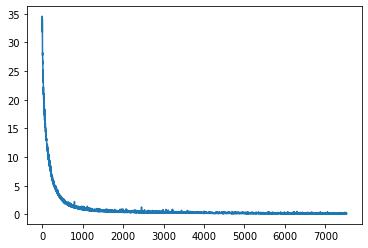

In [20]:
train_pred, val_AE_pred, _, _, scaler_x, _, model, device = AutoEncoder(X = X_train, y = X_train, num_epochs = 301, 
                                                           learning_rate = 0, reg_lambda = 0, 
                                                           hidden_units = 50, Batch = True, is_GPU_ON = True)


Now that the autoencoder is trained, we will use the sets called X_val, y_val, which have examples from both classes.

In [21]:
print(y_val)
y = y_val.copy()

[1 1 1 ... 0 0 0]


However, since we have to do some more training, in order to find the best threshold, we will once again split the sets into training and validation sets. Just one detail before doing the latter, since we trained the autoencoder in normalizaed data, we will normalize X_val using the "scaler" that was fit in the "AutoEncoder" function. 

In [22]:
X = scaler_x.transform(X_val)
X = torch.from_numpy(X.astype(np.float32))
X = X.to(device)

In [23]:
X_train_T, X_val_T, y_train_T, y_val_T = train_test_split(X, y, test_size = 0.2)   ### The "T" stands for threshold

train_pred_T, _ =  model.predict(X_train_T)
val_pred_T, _   =  model.predict(X_val_T  )


In [24]:
def predict_Anomalies(predictions, X, y, threshold):
    '''We will calculate the reconstruction error to determine which points are "normal" and which ones are anomalies.
    Additionally, we will plot the distribution of the reconstruction errors, so we can see how anomalies
    usually have larger erros '''
    
    
    sq_difference = torch.sum( (predictions -  X)**2, dim = 1, keepdim = True)
    sq_difference = sq_difference.cpu().numpy()
    sq_difference = np.sqrt(sq_difference)    
    


    plt.figure("Distribution of errors", figsize = (7,7))
    plt.title("Distribution of errors")
    sns.distplot(sq_difference)
    plt.xlabel("Reconstruction error")
    print( )
    print( )

    plt.figure("Scatterplot of errors", figsize = (7,7))
    plt.title("Scatterplot of errors")
    sns.scatterplot(sq_difference[:,0], sq_difference[:,0], hue = y, alpha=0.8)
    plt.xlabel("Reconstruction error")
    plt.ylabel("Reconstruction error")

    
    # y_prob = (    sigmoid(sq_difference - threshold)   )  
    
    # print(y_prob.shape)
    
    # plt.figure("Distribution of probabilities")
    # sns.distplot(y_prob)    
    
    # train_ROC_AUC = roc_auc_score(y, y_prob[:,0])
    # print("Training   AUC =", train_ROC_AUC )
            
    
    
    return sq_difference#, y_prob



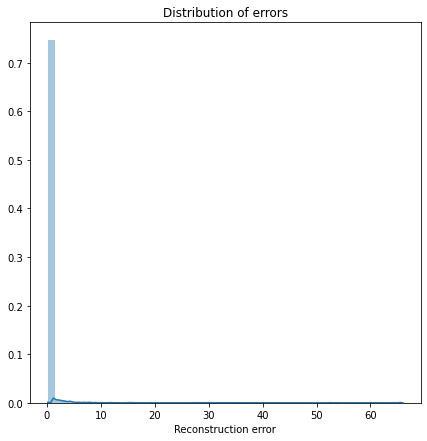

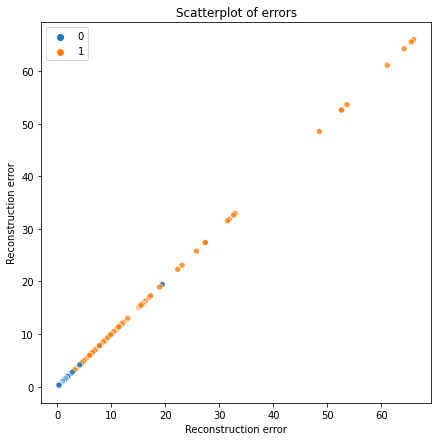

In [25]:
sq_difference_train = predict_Anomalies(train_pred_T, X_train_T, y_train_T, threshold = 3)

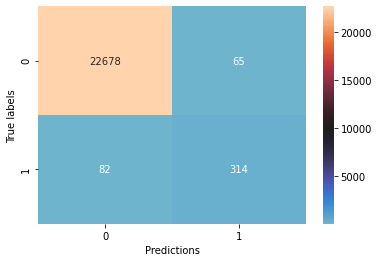

In [26]:
threshold = 2
train_pred_CLASS = (sq_difference_train > threshold).astype(int)

CR = classification_report(y_train_T, train_pred_CLASS)

CM = confusion_matrix(y_train_T, train_pred_CLASS)

plt.figure("Confusion Matrix")
sns.heatmap(CM, annot = True, fmt="d", center = 10000)
plt.xlabel("Predictions")
plt.ylabel("True labels")
print()

So, from the confusion matrix we can notice the following rate:

TPR = TP / ( TP + FN ),

which is known as the true positive rate (TPR), and, more importantly, is the quantity we would like to maximize. Or, in other words, we want to minimize the False Negatives, because we DO NOT want our algorithm to predict that some transaction is NOT a fraud when IT IS! A subtle detail, we should be very careful to NOT predict everything as a FRAUD, even thought it maximizes TPR. We have to find a balance, usually defined by the cost of calling to each client to verify their transactions.

For the purposes of this notebook, let's assume we cannot afford to have more than (approximately) 200 False Positives. What I want you to notice here is that we should only optimize one metric (whatever we think is the most important for our purposes), while other error measures (if any other relevant) can be treated as constraints. 

In [27]:
TPR = CM[1,1] / (CM[1,1] + CM[1,0] )
print("Training TPR = ", TPR)

Training TPR =  0.7929292929292929


So far, we have achieved a TPR of approxiamtely 0.8, which means that we are classifying correctly 80% of the frauds. An even better option is to come up with a metric that combines all the errors we want to minimize. Luckily for us, for this task exist an ideal candidate, the F1 score. The F1 score is the harmonic mean of 'precision' and 'recall', and, just for completeness, let's remember what these names mean.

Precision = TP / (TP + FP)

Recall    = TP / (TP + FN)

Then for our problem we have:




In [28]:
train_f1_score = f1_score(y_train_T, train_pred_CLASS)
print("Training F1 score =", train_f1_score)

Training F1 score = 0.8103225806451614


To finalize this section let's get the TPR and F1 score for the validation set X_val_T.

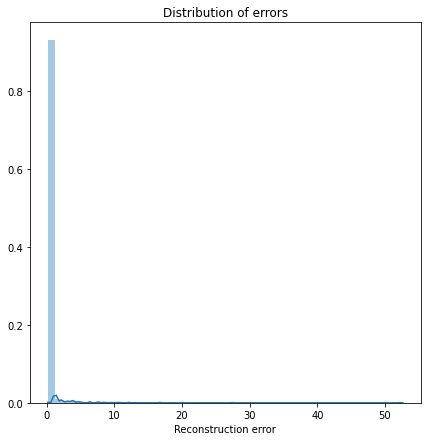

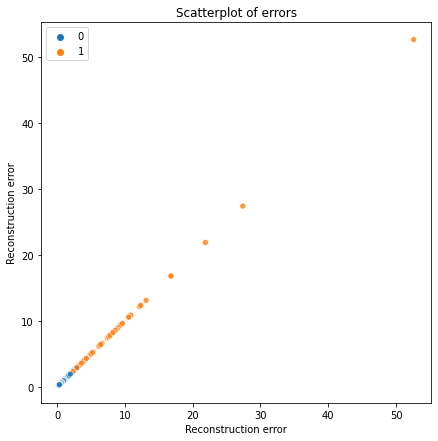

In [29]:
sq_difference_val = predict_Anomalies(val_pred_T, X_val_T, y_val_T, threshold = 2)

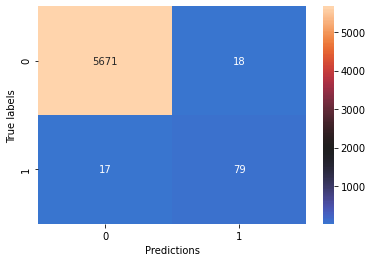

In [30]:
threshold = 2
val_pred_CLASS = (sq_difference_val > threshold).astype(int)

CR = classification_report(y_val_T, val_pred_CLASS)

CM = confusion_matrix(y_val_T, val_pred_CLASS)

plt.figure("Confusion Matrix")
sns.heatmap(CM, annot = True, fmt="d", center = 2000)
plt.xlabel("Predictions")
plt.ylabel("True labels")
print()

In [31]:
TPR = CM[1,1] / (CM[1,1] + CM[1,0] )
val_f1_score = f1_score(y_val_T, val_pred_CLASS)
print("Validation TPR = ", TPR)
print("Validation F1 score =", val_f1_score)

Validation TPR =  0.8229166666666666
Validation F1 score = 0.8186528497409326


# Last part

For the last part, we will train an isolation forest algorithm in the same dataset we used for the autoencoder. Just in case you skipped the last section let's load the data again.

In [32]:
df = pd.read_csv('creditcard.csv')
df.drop(columns = ["Time"], axis = 1, inplace=True )

In [33]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


This time we will NOT separate the data into classes, rather we will perform the usual train/validation split.

In [34]:
y = np.array(df.Class.copy())
df.drop(columns = ['Class'], axis = 1, inplace = True)
X = np.array(df.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [35]:
from sklearn.ensemble import IsolationForest 

In [36]:
scaler = StandardScaler()
pca = PCA(n_components = 29) # We can play with this hyperparameter to see what effects have changing the dimensionality.

X_train = pca.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_val   = pca.transform(X_val)
X_val   = scaler.transform(X_val)



So, what is the idea behind an isolation forest? Well, it's actually a pretty intuitive algorithm. What we have to do is to select a feature, at random, and randomly select a value between the maximum and minimum values of that feature, then, split the data. Continuing with this process will, eventually, segregate the points, and finally, all we have to do is to count the number of partitions requiered to do this. What we notice, is that the number of partitions needed to isolate 'normal' points is significantly larger than the number of partitions needed to isolate the anomalies (outliers), so we classify them based on that.

In [37]:
model_IF = IsolationForest()

In [38]:
model_IF.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [39]:
y_pred_train_IF = model_IF.predict(X_train)

The output for the Isolation Forest class in sklearn is +1 for inlier and -1 for outlier (anomaly), so we turn into the familiar 0 and 1 classes, and calculate the confusion matrix.

In [40]:
y_pred_train_IF = (- y_pred_train_IF + 1 ) // 2

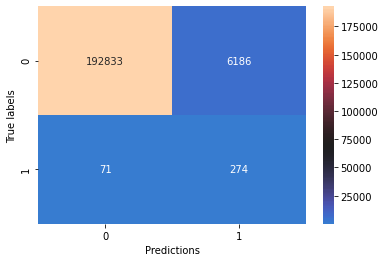

In [41]:
CR = classification_report(y_train, y_pred_train_IF)

CM = confusion_matrix(y_train, y_pred_train_IF)

plt.figure("Confusion Matrix")
sns.heatmap(CM, annot = True, fmt="d", center = 70000)
plt.xlabel("Predictions")
plt.ylabel("True labels")
print()

In [42]:
TPR = CM[1,1] / (CM[1,1] + CM[1,0] )
train_f1_score = f1_score(y_train, y_pred_train_IF)

print("Training TPR = ", TPR)
print("Training F1 score = ", train_f1_score)


Training TPR =  0.7942028985507247
Training F1 score =  0.08052902277736958


As we can see, the TPR is quite decent, HOWEVER, the number of False Positives is quite LARGE, and in practice this could be a disaster since the amount of resources used to verify them may exceed the ones available. Moreover, we can see that the F1 score is very small.

Finally, let's see the confusion matrix and the values for the TPR and F1 score for the validation set.

In [43]:
y_pred_val_IF = model_IF.predict(X_val)
y_pred_val_IF = (- y_pred_val_IF + 1 ) // 2

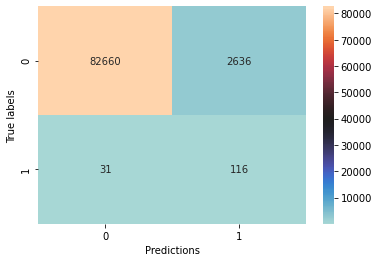

In [44]:
CR = classification_report(y_val, y_pred_val_IF)

CM = confusion_matrix(y_val, y_pred_val_IF)

plt.figure("Confusion Matrix")
sns.heatmap(CM, annot = True, fmt="d", center = 40000)
plt.xlabel("Predictions")
plt.ylabel("True labels")
print()

In [45]:
TPR = CM[1,1] / (CM[1,1] + CM[1,0] )
val_f1_score = f1_score(y_val, y_pred_val_IF)

print("Validation TPR = ", TPR)
print("Validation F1 score = ", val_f1_score)


Validation TPR =  0.7891156462585034
Validation F1 score =  0.08002759572266299
